## Isotropic Mixtures in `pyVBRc`

While the scaling relationships in the VBRc are formulated for olivine, comparing predicted seismic velocities from the VBRc to observations often requires considering compositional variations present in the upper mantle. 

To aid in that, `pyVBRc` provides the `pyVBRc.materials` modulue to aid in simple volume averaging of specified phases. 

### The `IsotropicMedium` class

Let's begin with a description independent of the VBRc. 

The `IsotropicMedium` class in `pyVBRc.materials` let's you specify elastic constants for an isotropic material:


In [1]:
from pyVBRc.materials import IsotropicMedium

In [2]:
IsotropicMedium?

Init signature:
IsotropicMedium(
    poisson_ratio: Union[float, numpy._typing._array_like._SupportsArray[numpy.dtype[Any]], numpy._typing._nested_sequence._NestedSequence[numpy._typing._array_like._SupportsArray[numpy.dtype[Any]]], bool, int, complex, str, bytes, numpy._typing._nested_sequence._NestedSequence[Union[bool, int, float, complex, str, bytes]]],
    modulus: Union[float, numpy._typing._array_like._SupportsArray[numpy.dtype[Any]], numpy._typing._nested_sequence._NestedSequence[numpy._typing._array_like._SupportsArray[numpy.dtype[Any]]], bool, int, complex, str, bytes, numpy._typing._nested_sequence._NestedSequence[Union[bool, int, float, complex, str, bytes]]],
    modulus_type: str,
    density: Union[float, numpy._typing._array_like._SupportsArray[numpy.dtype[Any]], numpy._typing._nested_sequence._NestedSequence[numpy._typing._array_like._SupportsArray[numpy.dtype[Any]]], bool, int, complex, str, bytes, numpy._typing._nested_sequence._NestedSequence[Union[bool, int, float,

To use it, specify a poisson ratio and a modulus (the shear, Youngs, or bulk modulus). In the following cell, we'll specify two materials with different shear moduli and densities:

In [3]:
m1 = IsotropicMedium(0.25, 60*1e9, 'shear', density=2800)
m2 = IsotropicMedium(0.25, 80*1e9, 'shear', density=3300)

An instance of the `IsotropicMedium` class will have a number of attributes available, including all of the engineering moduli:

In [4]:
m1.bulk_modulus/1e9, m1.shear_modulus/1e9, m1.lame_first_parameter/1e9, m1.poisson_ratio

(100.0, 60.0, 60.0, 0.25)

and because we specified a density, we also have shear and compressional wave velocities:

In [5]:
m1.v_s, m1.v_p

(4629.100498862757, 8017.837257372731)

You can also specify inputs as arrays. In the following, we calculate the density-dependence of shear wave velocity at fixed values for all other parameters by providing 

Text(0, 0.5, 'Vs [m/s]')

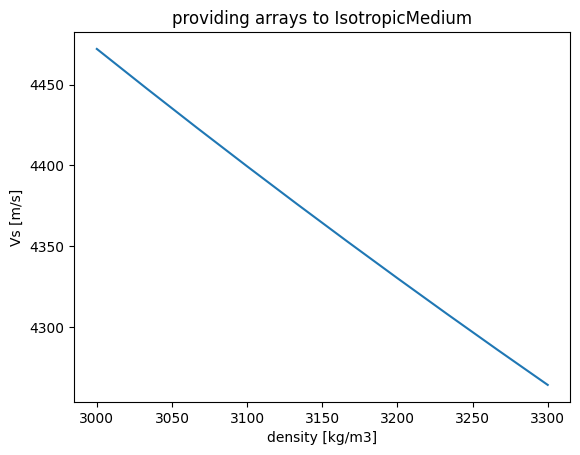

In [6]:
import numpy as np
import matplotlib.pyplot as plt

density = np.linspace(3000, 3300, 10) # density 
Gu = np.full((10,), 60*1e9) # unrelaxed shear modulus
m1 = IsotropicMedium(.25, 60*1e9, 'shear', density=density)
plt.plot(m1.density, m1.v_s)
plt.title("providing arrays to IsotropicMedium")
plt.xlabel("density [kg/m3]")
plt.ylabel("Vs [m/s]")

Or, a more interesting example, let's calculate the anharmonic temperature dependence at surface pressure. For this calculation, we'll specify how both shear modulus and density vary with temperature with the following constants:

In [7]:
dGdT = -13.6*1e6 # anharmonic temperature derivative of shear modulus, Pa/K
Gu_0_ol = 81 * 1e9 # unrelaxed shear modulus in Pa at reference T, P
Tref_K = 300 # reference T in K
thermal_exp = 3*1e-5 # coefficient of thermal expansion

and calculate the temperature-dependent modulus and density:

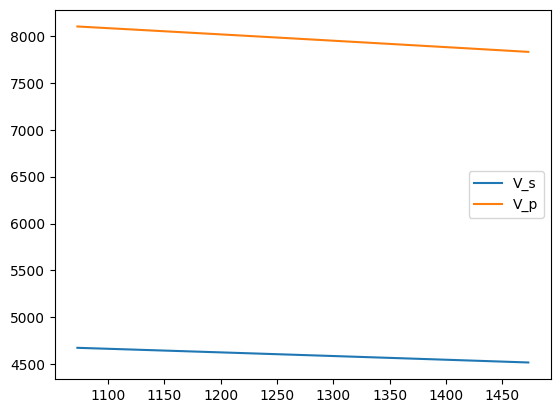

In [8]:
T_K = np.linspace(800, 1200, 100) + 273
Gu = Gu_0_ol + dGdT * (T_K - Tref_K)
density = 3300 * (1 - (T_K - Tref_K)* thermal_exp)
m1 = IsotropicMedium(.25, Gu, 'shear', density=density)
plt.plot(T_K, m1.v_s, label='V_s')
plt.plot(T_K, m1.v_p, label='V_p')
plt.legend()

## Isotropic Medium from VBRc

You can initialize an `IsotropicMedium` instance using the `load_isotropic_medium` function by providing a `vbr` structure that you've loaded with `VBRCstruct`. 

For example, using the small sample file, first load in the structure:

In [9]:
from pyVBRc.materials import load_isotropic_medium
from pyVBRc.sample_data import get_sample_filename
from pyVBRc.vbrc_structure import VBRCstruct

file = get_sample_filename("VBRc_sample_LUT.mat")
vbr = VBRCstruct(file, lut_dimensions=["T_K", "phi", "dg_um"])

pyVBRc : [INFO ] 2023-09-01 14:56:25,308:  /Users/chavlin/src/vbr_/pyVBRc/pyVBRc/sample_data/VBRc_sample_LUT.mat loaded.


and then supply `load_isotropic_medium` both the `vbr` variable as well as the location of the shear modulus you want to use. For example, to use the unrelaxed anharmonic modulus at `vbr.output.elastic.anharmonic.Gu`, you would supply:

In [10]:
m = load_isotropic_medium(vbr, ("elastic", "anharmonic", "Gu"))

this is useful for creating `IsotropicMedium` instances that you can then mix together. For example, you can use the VBRc to calculate the the properties of endmembmers, and then use the mixing methods below to combine the endmembers.

## Mixtures of IsotropicMedium instances

The `IsotropicMixture` class will take a list of `IsotropicMedium` instances along with their proportions and calculate properties of an isotropic composite. 

In [11]:
from pyVBRc.materials import IsotropicMixture

In [12]:
IsotropicMixture?

Init signature:
IsotropicMixture(
    materials: List[pyVBRc.materials.materials.IsotropicMedium],
    proportions: Union[numpy._typing._array_like._SupportsArray[numpy.dtype[Any]], numpy._typing._nested_sequence._NestedSequence[numpy._typing._array_like._SupportsArray[numpy.dtype[Any]]], bool, int, float, complex, str, bytes, numpy._typing._nested_sequence._NestedSequence[Union[bool, int, float, complex, str, bytes]]],
)
Docstring:      <no docstring>
File:           ~/src/vbr_/pyVBRc/pyVBRc/materials/materials.py
Type:           type
Subclasses:     

so let's create a couple of endmembers. 

Let's create endmembers for forsterite (Fo) and fayalite (Fa). The values for the poisson ratio, shear modulus and density come from Hacker and Abers 2004, for surface conditions:

```
Subduction Factory 3: An Excel worksheet and macro for calculating the densities, seismic wave speeds, and H2O contents of minerals and rocks at pressure and temperature
Bradley R. Hacker, Geoffrey A. Abers
First published: 20 January 2004
https://doi.org/10.1029/2003GC000614
```

In [13]:
Fo = IsotropicMedium(0.241, 78*1e9, 'shear', density=3100)
Fa = IsotropicMedium(0.335, 50*1e9, 'shear', density=4300) 

and now we can create a mixture by providing a list of the endmembers and the mixing proportions:



In [14]:
mixture = IsotropicMixture([Fo, Fa], [0.5, 0.5])

the density is a simple volumetric average:

In [15]:
mixture.density()

3700.0

while the moduli can be calculated with Voit, Reuss, or Voit-Reuss averaging:

In [16]:
mixture.shear_modulus?

Signature: mixture.shear_modulus(method: str = 'voigt-reuss')
Docstring:
Parameters
----------
method: str
    voigt, reuss or voigt-reuss (the default)

Returns
-------
File:      ~/src/vbr_/pyVBRc/pyVBRc/materials/materials.py
Type:      method

In [17]:
mixture.shear_modulus()/1e9

62.46875

To calculate the dependence on the mixing proportions, you can use a loop to vary the volume fraction. 

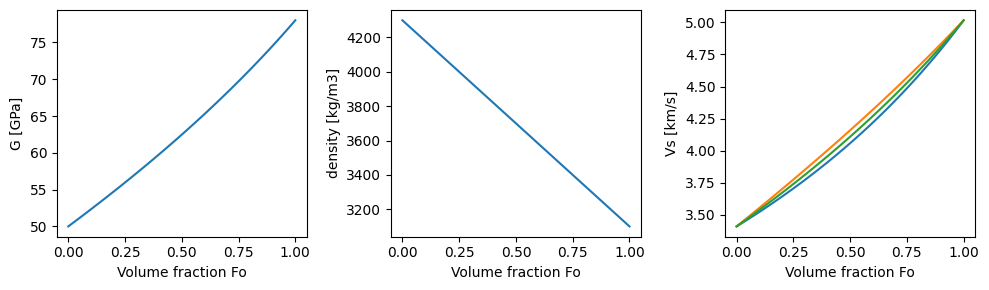

In [18]:
G = []
density = []
vs_v = []
vs_r = []
vs_vr = []
fracs_fo = np.linspace(0, 1, 50)
for frac_fo in fracs_fo:
    mixture = IsotropicMixture([Fo, Fa], [frac_fo, 1.0 - frac_fo])
    G.append(mixture.shear_modulus()/1e9)
    vs_v.append(mixture.shear_velocity(method='voigt')/1e3)
    vs_r.append(mixture.shear_velocity(method='reuss')/1e3)
    vs_vr.append(mixture.shear_velocity(method='voigt-reuss')/1e3)
    density.append(mixture.density())

f, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

axs[0].plot(fracs_fo, G)
axs[0].set_ylabel('G [GPa]')
axs[1].plot(fracs_fo, density)
axs[1].set_ylabel('density [kg/m3]')
axs[2].plot(fracs_fo, vs_r, label='reuss')
axs[2].plot(fracs_fo, vs_v, label='voigt')
axs[2].plot(fracs_fo, vs_vr, label='voigt-reuss')
axs[2].set_ylabel('Vs [km/s]')

for ax in axs:
    ax.set_xlabel('Volume fraction Fo')
f.tight_layout()
                      